In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import math
from mpmath import *
from sympy import Symbol, solveset, S, erf, log, sqrt
from itertools import cycle
from numpy import ma
from matplotlib import ticker, cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
mp.dps = 2 # accuracy
mp.pretty = True

In [2]:
particle_density = 997 # kg/m^3
fluid_density = 1.255 # kg/m^3
dynamic_viscosity_air_25C = 1.849e-5
mean_free_path_air_25C = 6.826e-8

reynolds_max = None
reynolds_min = None

In [3]:
def euler(xy_n, delta_t, funcs):
    # 2D euler
    x_n = xy_n[0] + delta_t*funcs[0]
    y_n = xy_n[1] + delta_t*funcs[1]
    return [x_n, y_n]

Re = lambda v, particle_diameter: fluid_density*v*particle_diameter/dynamic_viscosity_air_25C  #not entirely accurate

# Slip correction factor
C_c = lambda particle_diameter: 1 + 2*mean_free_path_air_25C/particle_diameter*(1.257+0.4*math.e**(-1.1*particle_diameter/(2*mean_free_path_air_25C)))

def C_d(Re):
    global reynolds_max 
    global reynolds_min
    #if reynolds_max is None or Re > reynolds_max:
     #   reynolds_max = Re
    #if reynolds_min is None or Re < reynolds_min:
     #   reynolds_min = Re
    if Re < 0.1:
        return 24/Re
    elif Re > 0.1 and Re < 0.2:
        return 24/Re*(1+3/16*Re+9/160*Re**2*log(2*Re))
    elif Re > 0.2 and Re < 500:
        return 24/Re*(1+0.15*Re**0.686)
    elif Re > 500 and Re < 2e5:
        return 0.44
    elif Re > 2e5:
        raise Exception('Reynolds number to large')
    
def F_drag(v, particle_diameter):
    #print('v', v, 'F_drag particle_diameter', particle_diameter)
    # also add drag force = 0 if velocity is 0
    if particle_diameter <= 10e-6:
        return (3*math.pi*dynamic_viscosity_air_25C*v*particle_diameter)/(C_c(particle_diameter)*(2/particle_diameter))
    else:
        return math.pi/8*C_d(Re(v, particle_diameter))*fluid_density*particle_diameter**2*v**2

F_g = lambda particle_mass: particle_mass*constants.g
F_b = lambda particle_volume: fluid_density*particle_volume*constants.g

def acceleration(v, speed, particle_diameter):
    particle_volume = 4/3*math.pi*(particle_diameter/2)**3
    particle_mass = particle_volume*particle_density
    
    velocity_unitvector_x = v[0]/speed
    velocity_unitvector_y = v[1]/speed
    drag_force = F_drag(speed, particle_diameter)
    drag_force_x = -1*velocity_unitvector_x*drag_force
    drag_force_y = -1*velocity_unitvector_y*drag_force

    a_x = drag_force_x/particle_mass
    a_y = (-F_g(particle_mass) + drag_force_y + F_b(particle_volume))/particle_mass
    #print(f'{v = }\n', f'{speed = }\n', f'{velocity_unitvector_x = }\n', f'{velocity_unitvector_y = }\n', f'{drag_force = }\n', f'{drag_force_x = }\n', f'{drag_force_y = }\n', f'{a_x = }\n',f'{a_y = }\n\n')
    return [a_x, a_y]

def euler_step(v, pos, particle_diameter, delta_t, air_velocity_field, air_pressure_field, t):
    # velocity field
    v_air =  air_velocity_field(pos)
    v_actual = np.add(v, v_air)
    speed = (v_actual[0]**2+v_actual[1]**2)**(1/2)
    
    if(air_pressure_field):
        pressure = air_pressure_field(pos)
        particle_diameter_new = particle_diameter + diameter_change_due_to_evaporation(t, particle_diameter, pressure, speed)
        #print('speed', speed, 'v', v, 't', t, 'particle_diameter', particle_diameter, 'pressure', pressure, 'particle_diameter_new', particle_diameter_new)
    else:
        particle_diameter_new = particle_diameter # no evaporation case

    if(not math.isnan(particle_diameter_new) and particle_diameter_new > 0):
        # holds for evaporation and non evaporation case
        pos_new = euler(pos, delta_t, v_actual)
        a_new = acceleration(v_actual, speed, particle_diameter_new)
        v_new = euler(v_actual, delta_t, a_new)
    else:
        # define standard return values in case droplet evaportates
        a_new = [0, 0]
        v_new = [0, 0]
        pos_new = pos
        particle_diameter_new = 0
    
    return {
        'a': a_new,
        'v': v_new,
        'pos': pos_new,
        'd': particle_diameter_new
    }

In [124]:
def particle_simulation(particle_diameter_init, v_init, pos_init, experiment_time, delta_t, air_velocity_field, air_pressure_field=None, collision_detection=None ):
    steps = np.arange(0, experiment_time, delta_t)
    n_steps = math.ceil(experiment_time/delta_t)
    v = np.zeros(shape=(n_steps + 1, 2))
    pos = np.zeros(shape=(n_steps + 1, 2))
    particle_diameter = np.zeros(shape=(n_steps + 1))
    
    v[0] = v_init
    pos[0] = pos_init
    particle_diameter[0] = particle_diameter_init
    has_colided = False
    
    for id, step in enumerate(steps):
        t = delta_t*step
        # compute new values
        #print('particle_diameter[id]', particle_diameter[id])
        new_values = euler_step(v[id], pos[id], particle_diameter[id], delta_t, air_velocity_field, air_pressure_field, t)

        # add new values
        v[id+1] = new_values['v']
        pos[id+1] = new_values['pos']
        particle_diameter[id+1] = new_values['d']
        
        if(collision_detection):
            has_colided=collision_detection(new_values['pos'])
    
        if(new_values['d'] == 0 or has_colided):
            print('has_colided', has_colided, 'pos', new_values['pos'])
            if(new_values['d'] == 0):
                print('particle evaporated')
            elif(has_colided):
                print('particle collided')
            # particle evaporated fully => break iteration early
            # do not return the empty initialized zeroes
            return {
                'v': v[0:id+1],
                'pos': pos[0:id+1],
                'd': particle_diameter[0:id+1]
            }

    return {
        'v': v,
        'pos': pos,
        'd': particle_diameter
    }

In [5]:
simulations = [
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [5, 0]
    },
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [10, 0]
    },
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [17, 0]
    },
    {
        'type': 'cough',
        'd': [1e-6, 100e-6, 1000e-6],
        'v': [20, 0]
    }
]

simulations_test = [
    {
        'type': 'cough',
        'd': [1e-6],
        'v': [20, 2]
    }
]

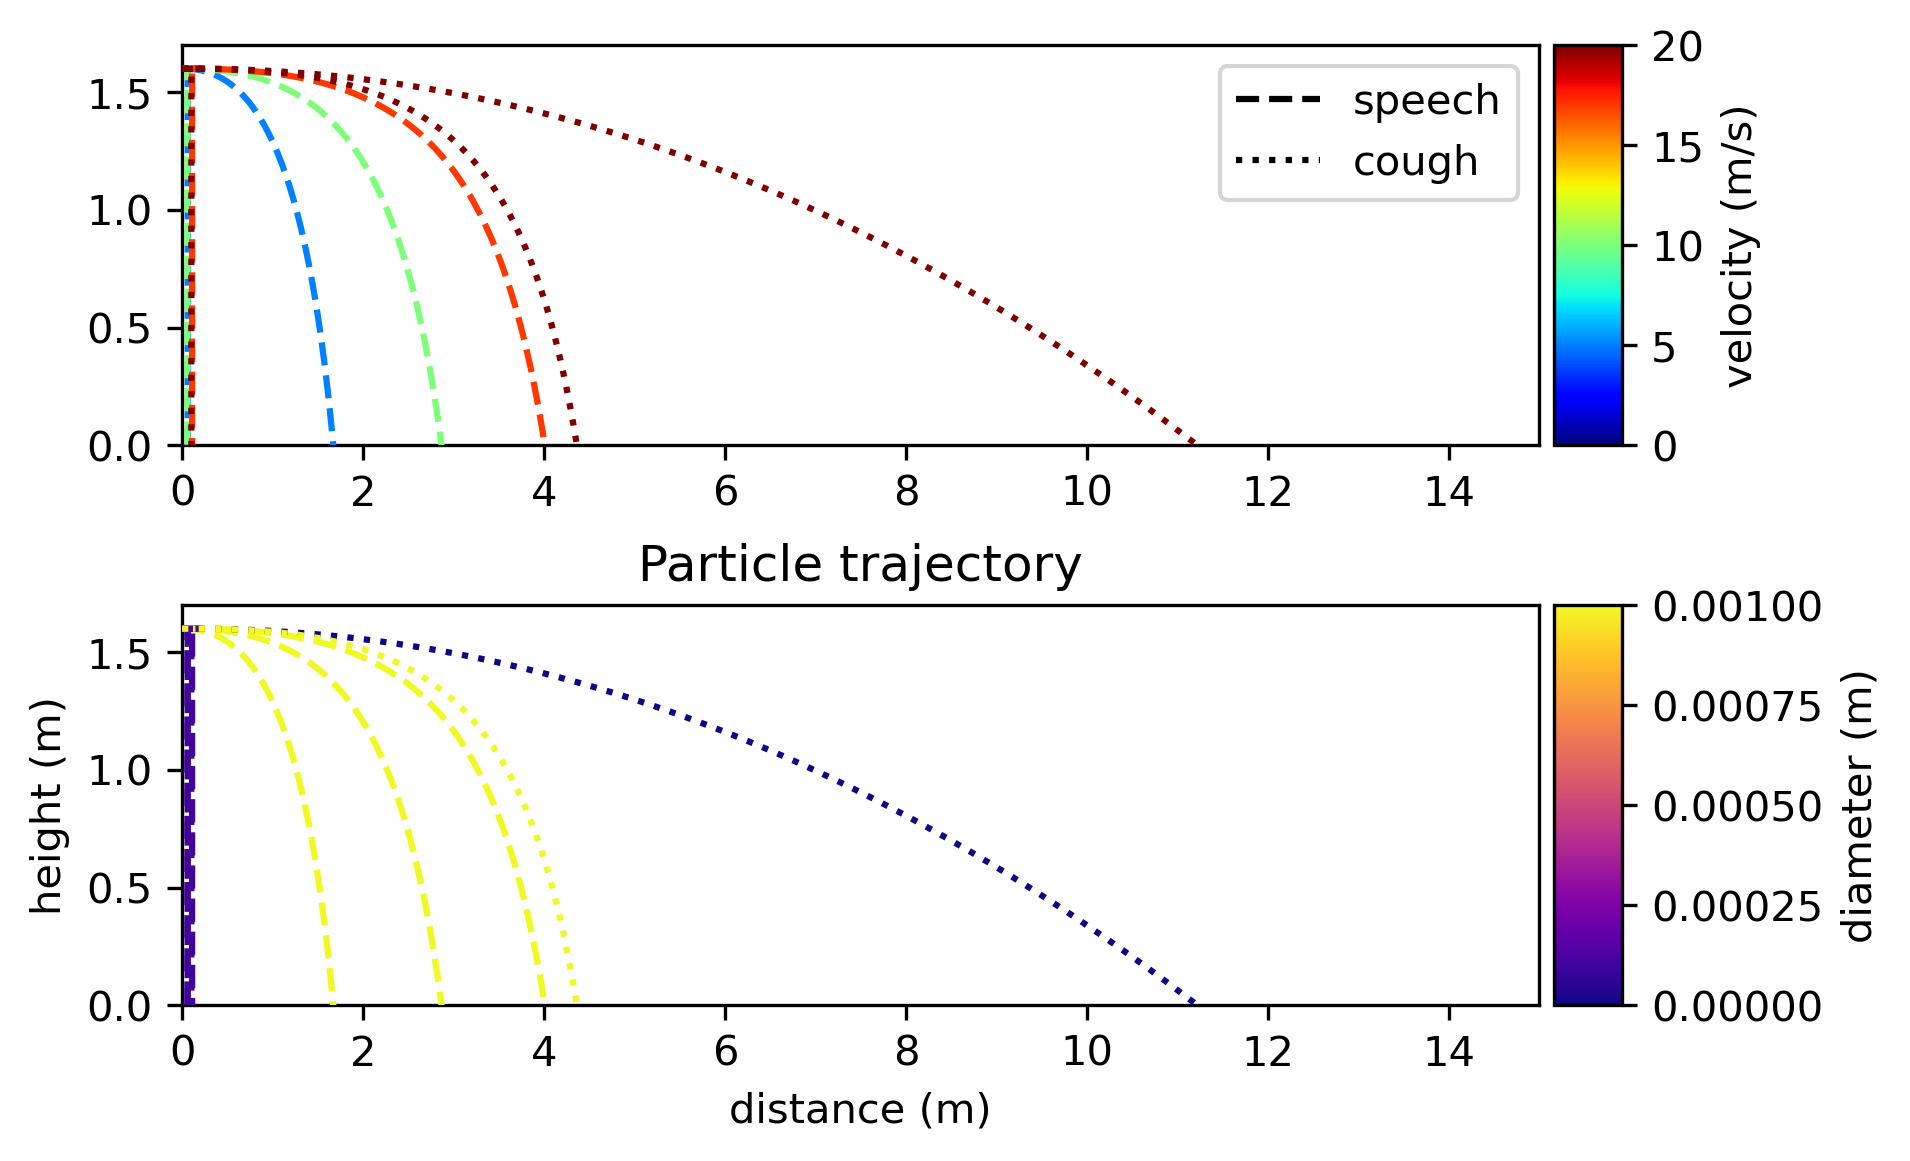

In [6]:
experiment_time = 20
delta_t = 0.01
pos_init = [0, 1.6]
air_velocity_field = lambda pos: [0,0]
u, v = 0, 0.04 # air velocity field

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

ax1.set_xlim([0, 15])
ax1.set_ylim([0, 1.7])
ax2.set_xlim([0, 15])
ax2.set_ylim([0, 1.7])

plt.title('Particle trajectory')
plt.xlabel('distance (m)')
plt.ylabel('height (m)')
fig.set_dpi(300)

color_map_v = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=20))
color_map_d = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=1000e-6))

for simulation in simulations:
    for particle_diameter in simulation['d']:
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        #linestyle=':' if simulation['type'] == 'speech' else 'dotted', label=simulation['label']
        ax1.plot(pos_x, pos_y, c=color_map_v.to_rgba(simulation['v'][0]), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        ax2.plot(pos_x, pos_y, c=color_map_d.to_rgba(particle_diameter), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)        
fig.colorbar(color_map_v, label='velocity (m/s)', cax=cax, orientation='vertical')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(color_map_d, label='diameter (m)', cax=cax, orientation='vertical')

lineSpeech = Line2D([0,1],[0,1],linestyle='dashed', color='black')
lineCough = Line2D([0,1],[0,1],linestyle='dotted', color='black')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.legend([lineSpeech, lineCough],['speech', 'cough'])

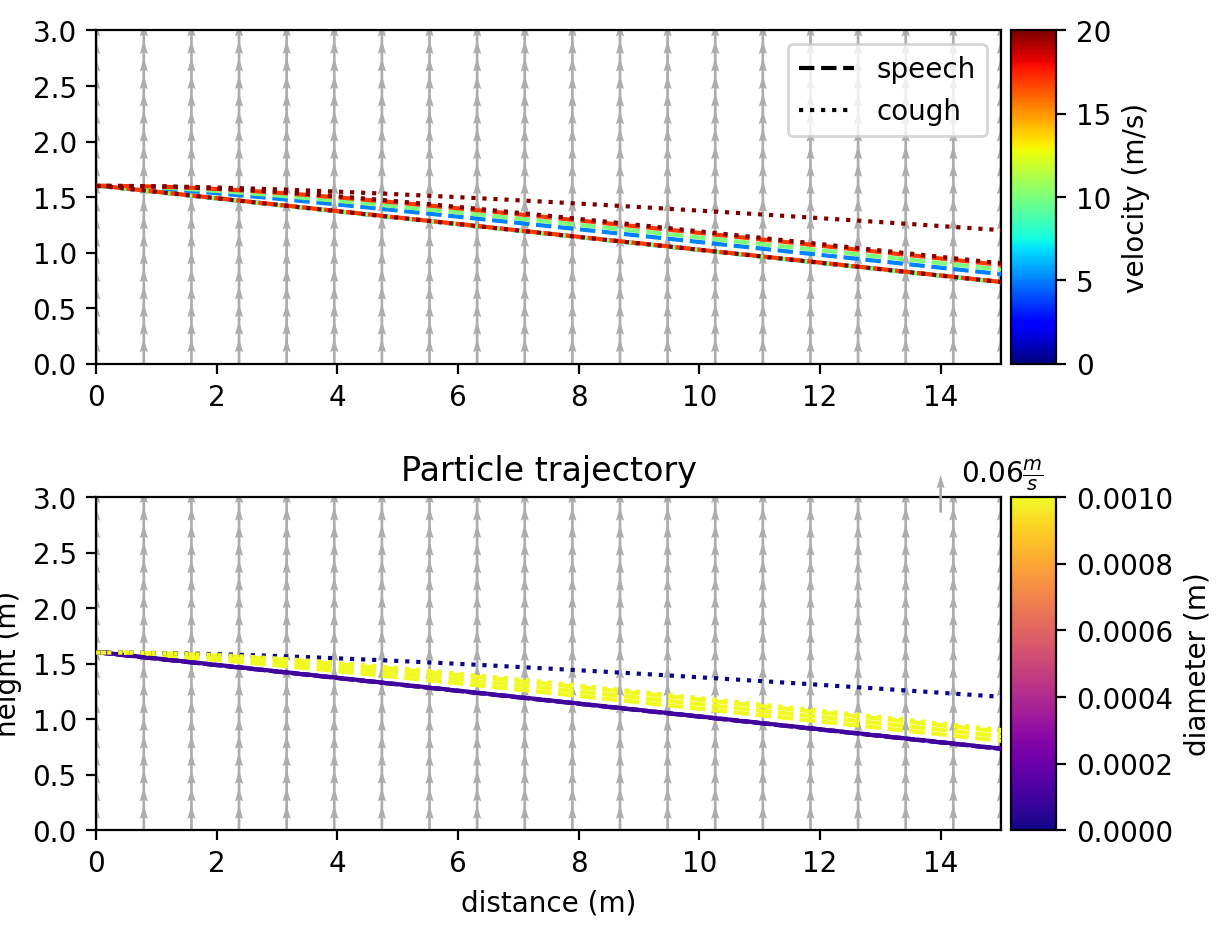

In [7]:
experiment_time = 20
delta_t = 0.01
pos_init = [0, 1.6]
air_velocity_field = lambda pos: [1,0.04]
u, v = 0, 0.04 # air velocity field

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

ax1.set_xlim([0, 15])
ax1.set_ylim([0, 3])
ax2.set_xlim([0, 15])
ax2.set_ylim([0, 3])

plt.title('Particle trajectory')
plt.xlabel('distance (m)')
plt.ylabel('height (m)')
fig.set_dpi(200)

color_map_v = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=20))
color_map_d = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=1000e-6))

for simulation in simulations:
    for particle_diameter in simulation['d']:
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        #linestyle=':' if simulation['type'] == 'speech' else 'dotted', label=simulation['label']
        ax1.plot(pos_x, pos_y, c=color_map_v.to_rgba(simulation['v'][0]), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        ax2.plot(pos_x, pos_y, c=color_map_d.to_rgba(particle_diameter), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)        
fig.colorbar(color_map_v, label='velocity (m/s)', cax=cax, orientation='vertical')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(color_map_d, label='diameter (m)', cax=cax, orientation='vertical')

lineSpeech = Line2D([0,1],[0,1],linestyle='dashed', color='black')
lineCough = Line2D([0,1],[0,1],linestyle='dotted', color='black')

#quiver
x_mesh,y_mesh = np.meshgrid(np.linspace(0,15,20), np.linspace(0,3,20))
qv1 = ax1.quiver(x_mesh, y_mesh, u, v, color='#adadad', zorder=0)
qv2 = ax2.quiver(x_mesh, y_mesh, u, v, color='#adadad', zorder=0)
plt.quiverkey(qv2, 14, 3.2, 0.06, r'$0.06\frac{m}{s}$', coordinates='data', angle=90, labelpos='E')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.1, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.legend([lineSpeech, lineCough],['speech', 'cough'])

In [8]:
stream_traces = pd.read_csv('./export_stream_trace.csv')

In [9]:
stream_traces_i = stream_traces
#stream_traces_i = pd.concat([stream_traces, pd.DataFrame({'Points:0':np.arange(0, 15, 0.001), 'Points:1': np.arange(0, 15, 0.001)})], ignore_index=True, axis=0)
#stream_traces_i = stream_traces_i.interpolate()
#stream_traces.sort_values('Points:0')

In [10]:
stream_traces[stream_traces['Points:0'] == 1.73940]['U:1']

497007    0.43863
512695    0.11076
Name: U:1, dtype: float64

In [107]:
# def find_neighbours(value, df, colname):
#     try:
#         exactmatch = df[df[colname] == value]
#         if not exactmatch.empty:
#             return exactmatch.index
#         else:
#             lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
#             upperneighbour_ind = df[df[colname] > value][colname].idxmin()
#             return [lowerneighbour_ind, upperneighbour_ind]
#     except ValueError:
#         print('Neighbour Value Error')
#         return [1]

In [35]:
simulations_train= [
    {
        'person': 1,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 2,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 3,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 6,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 8,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 10,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 11,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 15,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 17,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    },
    {
        'person': 18,
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    }
]

In [108]:
def build_train_coordinates(number_of_seats):
    # plot the train interior walls
    x = [0]
    y = [0]
    for i in range(number_of_seats):
        seat_n = i+1
        shift_x = (seat_n*1.1)
        x.extend([0+shift_x, 0.5+shift_x, 0.5+shift_x, 1+shift_x, 1+shift_x, 1.1+shift_x, 1.1+shift_x])
        y.extend([0, 0, 0.5, 0.5, 1, 1, 0])
    return [x, y]

In [109]:
def collision_detection(train, pos):
    y = train.iloc[(train['x_train']-12).abs().argsort()[:1]]['y_train'].values[0]
    if(y >= pos[1]):
        return True
    return False

In [104]:
[x_train, y_train] = build_train_coordinates(10)
train =  pd.DataFrame({'x_train': x_train, 'y_train': y_train})
collision_detection_initialised = collision_detection_init(x_train, y_train)
neighbours = find_neighbours(1.2, train, 'x_train')
y = train.iloc[neighbours[0]]['y_train']


1.0

In [19]:
def collision_detection_init(x_train, y_train):
    train = pd.DataFrame({'x_train': x_train, 'y_train': y_train})
    return lambda pos: collision_detection(train, pos)

person:  1
particle collided
person:  2
particle collided
person:  3
particle collided
person:  6
particle collided
person:  8
particle collided
person:  10
particle collided
person:  11
particle collided
person:  15
particle collided
person:  17
particle collided
person:  18
particle collided


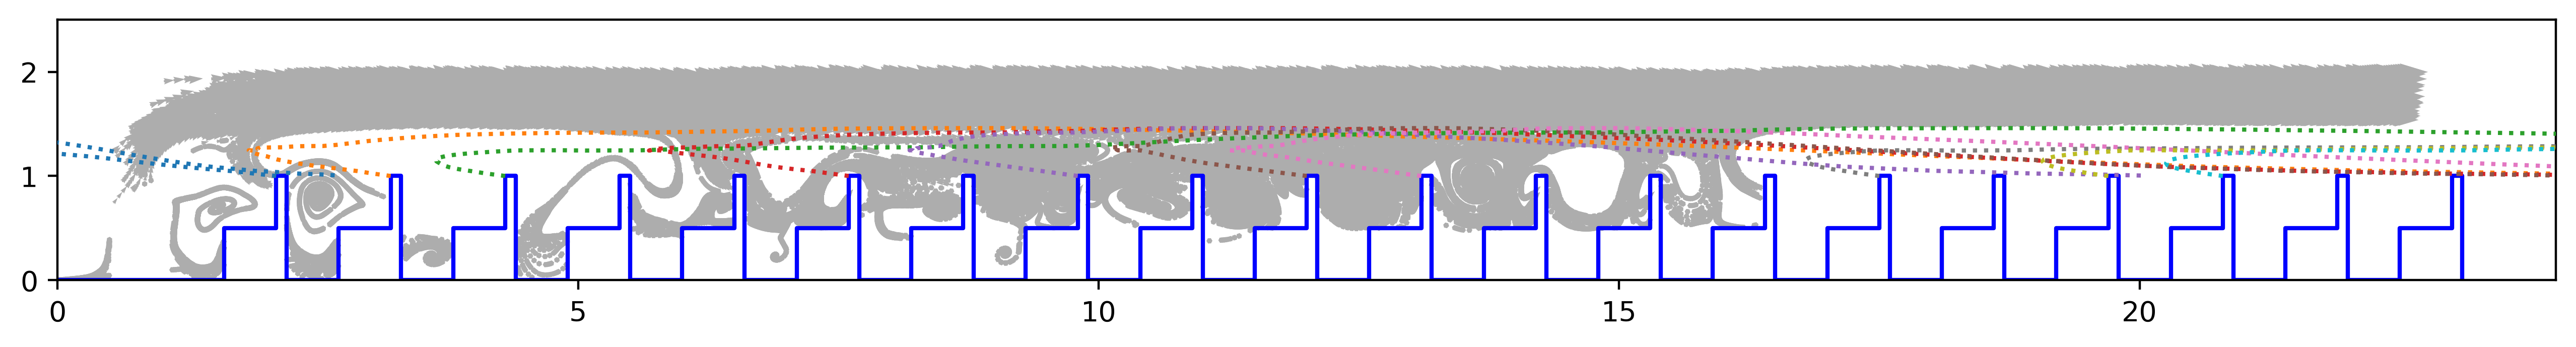

In [116]:
experiment_time = 1
delta_t = 0.01
total_seats = 20
exhalation_height = 1

fig, ax = plt.subplots(figsize=(16,5))
fig.set_dpi(400)
ax.set_xlim([0, 24])
ax.set_ylim([0, 2.5])
ax.set_aspect('equal', adjustable='box')
[x_train, y_train] = build_train_coordinates(total_seats)
ax.plot(x_train,y_train, color='blue')
collision_detection_initialised = collision_detection_init(x_train, y_train)


def air_velocity_field(pos):
    # find the closest available position from the openFoam data
    u_x = stream_traces_i.iloc[(stream_traces_i['Points:0']-pos[0]).abs().argsort()[:1]]['U:0'].values[0]
    u_y = stream_traces_i.iloc[(stream_traces_i['Points:1']-pos[1]).abs().argsort()[:1]]['U:1'].values[0]
    return [u_x, u_y]

for simulation in simulations_train:
    for particle_diameter in simulation['d']:
        print('person: ', simulation['person'])
        x_exhaling = 1.1-0.1+1.1*simulation['person'] # person width is 0.1 otherwise we have instantaneous collision
        pos_init = [x_exhaling, exhalation_height]
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field, None, collision_detection_initialised)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        ax.plot(pos_x, pos_y, linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
ax.quiver(stream_traces_i['Points:0'], stream_traces_i['Points:1'], stream_traces_i['U:0'], stream_traces_i['U:1'], color='#adadad', zorder=0)

In [26]:
diffusion_coefficient_water_in_air = 0.260*1e-4
saturation_pressure_water_1atm_25C = 3171 #Pa
temp = 273+25 #K
M_v = 18.05*1e-3 #g/mol molar mass water vapor
M_g = 28.96*1e-3 #g/mol molar mass air

surf_tension_water = 73e-3 #N/m
R_v = 461.9 #specific gas constant J/(kg*K)
vapor_mass_frac_inf = 0.01191 #Elena link

S_c = dynamic_viscosity_air_25C/(fluid_density*diffusion_coefficient_water_in_air) # Elana notes
sherwood2 = lambda particle_diameter: k_m*particle_diameter/diffusion_coefficient_water_in_air #33
sherwood = lambda v, particle_diameter: 2+0.6*Re(v, particle_diameter)**(1/2)*S_c**(1/3) #34
vapour_pressure = lambda particle_diameter: saturation_pressure_water_1atm_25C*e**(2*surf_tension_water/(particle_density*R_v*temp*particle_diameter/2)) #32
vapor_mass_frac_r = lambda particle_diameter, pressure: vapour_pressure(particle_diameter)*M_v/(vapour_pressure(particle_diameter)*M_v + (pressure - vapour_pressure(particle_diameter))*M_g) #31

diameter_change_due_to_evaporation = lambda t, particle_diameter, pressure, v: 2*t*(-1*fluid_density*diffusion_coefficient_water_in_air*sherwood(v, particle_diameter)/
                                                                      (2*particle_density*particle_diameter/2)*log((1-vapor_mass_frac_inf)/(1-vapor_mass_frac_r(particle_diameter, pressure)))) #41


In [37]:
diameter_change_due_to_evaporation(2, 10e-6, 100e3, 1)/10e-6 #percent change

-24.5424676742947

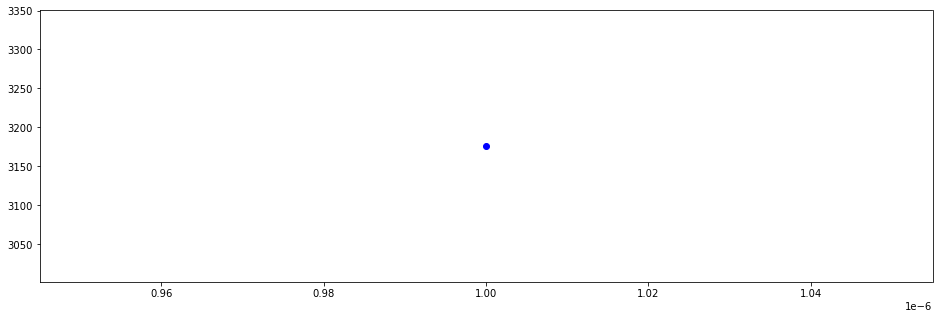

In [17]:
x = np.arange(1e-6, 1000e-6, 100)

fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x, vapour_pressure(x), color='blue')

In [23]:
simulations_train= [
    {
        'person': 1,
        'type': 'cough',
        'd': [10e-6],
        'v': [-2, 2]
    }
]

person:  1
has_colided True pos [11.360955595299105, -0.011013735081767617]
particle collided
person:  2
has_colided True pos [8.706331535853707, 0.0952289223813978]
particle collided
person:  3
has_colided True pos [9.930454982023218, 0.09151986742264129]
particle collided
person:  6
has_colided True pos [14.584135716849055, 0.04967627630992144]
particle collided
person:  8
has_colided True pos [16.566836688850717, 0.05691312959769779]
particle collided
person:  10
has_colided True pos [19.426602174559186, 0.037610029762432884]
particle collided
person:  11
has_colided True pos [18.71922882501829, 0.09100673720429542]
particle collided
person:  15
has_colided True pos [23.272491309671462, 0.08697484973490366]
particle collided
person:  17
has_colided True pos [24.873751094476336, 0.106754000365745]
particle collided
person:  18
has_colided True pos [25.928205853301943, 0.10850027302449305]
particle collided


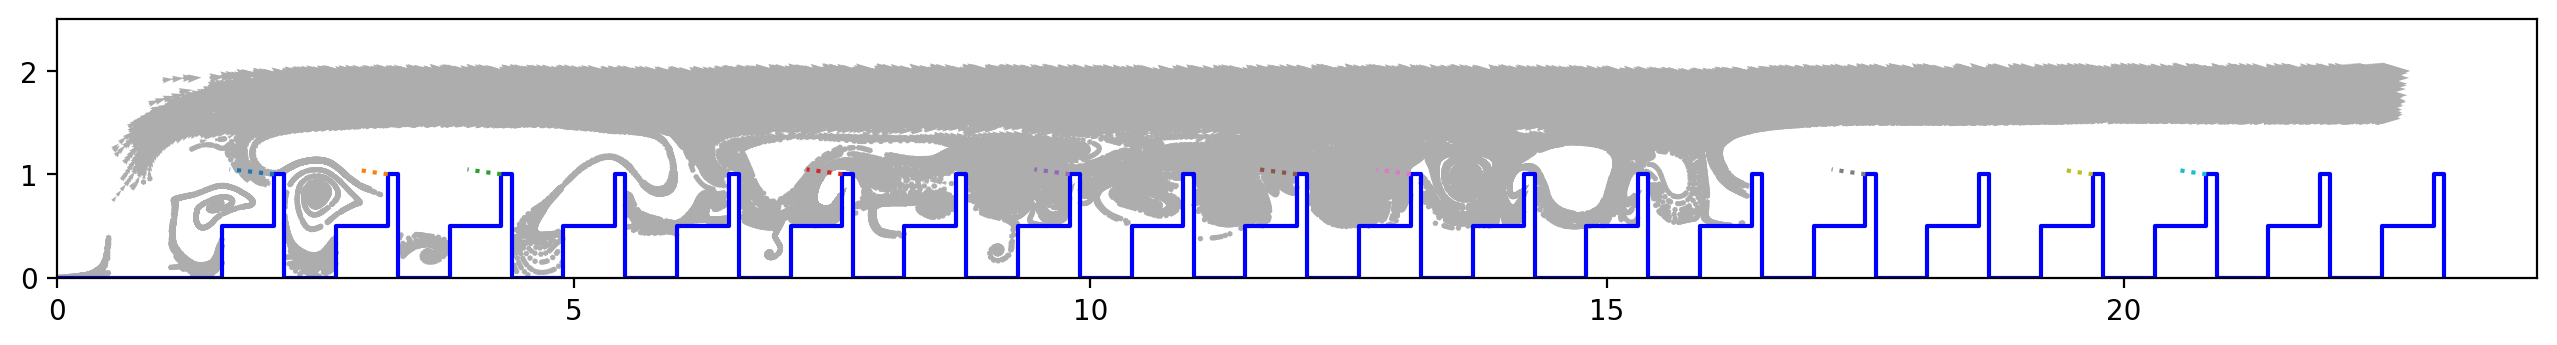

In [126]:
experiment_time = 1
delta_t = 0.01
total_seats = 20
exhalation_height = 1

fig, ax = plt.subplots(figsize=(16,5))
fig.set_dpi(200)
ax.set_xlim([0, 24])
ax.set_ylim([0, 2.5])
ax.set_aspect('equal', adjustable='box')

[x_train, y_train] = build_train_coordinates(total_seats)
ax.plot(x_train,y_train, color='blue')
collision_detection_initialised = collision_detection_init(x_train, y_train)

def air_pressure_field(pos):
     # find the closest available position from the openFoam data
    p = stream_traces_i.iloc[(stream_traces_i['Points:0']-pos[0]+stream_traces_i['Points:1']-pos[1]).abs().argsort()[:1]]['p'].values[0]
    return p

def air_velocity_field(pos):
    # find the closest available position from the openFoam data
    u_x = stream_traces_i.iloc[(stream_traces_i['Points:0']-pos[0]).abs().argsort()[:1]]['U:0'].values[0]
    u_y = stream_traces_i.iloc[(stream_traces_i['Points:1']-pos[1]).abs().argsort()[:1]]['U:1'].values[0]
    return [u_x, u_y]
    
for simulation in simulations_train:
    for particle_diameter in simulation['d']:
        print('person: ', simulation['person'])
        x_exhaling = 1.1-0.1+1.1*simulation['person']
        pos_init = [x_exhaling, exhalation_height]
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field, air_pressure_field, collision_detection_initialised)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        ax.plot(pos_x, pos_y, linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
ax.quiver(stream_traces_i['Points:0'], stream_traces_i['Points:1'], stream_traces_i['U:0'], stream_traces_i['U:1'], color='#adadad', zorder=0)